### Training and evaluating SimCLR and Moco on Cifar10
* Train a MoCo model from scratch
* Evaluate the feature learned by MoCo by linear probe on the same dataset
* Finetune the model on a different dataset


##### First, Let's train a MoCo model
MoCo is proposed in the following paper: 

* Kaiming He, Haoqi Fan, Yuxin Wu, Saining Xie, and Ross Girshick. CVPR 2020. Momentum Contrast for Unsupervised Visual Representation Learning. https://arxiv.org/pdf/1911.05722.pdf

In [35]:
%%html
<img src="https://miro.medium.com/max/355/1*8tmQXmyo7tR_RQHJXRMydA.png", width=400, height=300>

In [38]:
%%html
<img src="https://ai-smile.site/20210728l1/image-20210728230313506.png", width=700, height=270>

In [2]:
from PIL import ImageFilter
import random
import torch
import torch.nn as nn
from PIL import Image
from torchvision.datasets import CIFAR10
from torch.utils.data import Dataset
import re
from os.path import join
import random
import shutil
import time
import warnings
from pathlib import Path
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.optim
import torch.utils.data
import torch.utils.data.distributed
import torchvision.transforms as transforms
import torchvision.models as models
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np
import torchvision
torch.cuda.set_device(2)

* First, we need to prepare the MoCo class that build a MoCo model with a query encoder, a key encoder and a queue corresponding to the MoCo structure below:

In [2]:
# Original MoCo model only support DistributedDataParallel (DDP) model
# Because in experiments, the authors found that using Batch Norm (BN) 
# prevents the model from learning good representations
# The model appears to “cheat” the pretext task and easily finds a low-loss solution.
# This is possibly because the intra-batch communication among samples (caused by BN) leaks information
# MoCo resolved this problem by shuffling BN. 
# MoCo trained with multiple GPUs and perform BN on the samples independently for each GPU. 
# For the key encoder fk, they shuffle the sample order in the current mini-batch before distributing it among GPUs 
# (and shuffle back after encoding); 
# the sample order of the mini-batch for the query encoder fq is not altered. 
# This ensures the batch statistics used to compute a query and its positive key come from two different subsets.
# 
# 
# However, here, to make it runable on jupyter notebook, I change it to support single device training procedure
class MoCo(nn.Module):
    """
    Build a MoCo model with: a query encoder, a key encoder, and a queue
    https://arxiv.org/abs/1911.05722
    """
    def __init__(self, base_encoder, dim=128, K=65536, m=0.999, T=0.07, mlp=False):
        """
        dim: feature dimension (default: 128)
        K: queue size; number of negative keys (default: 65536)
        m: moco momentum of updating key encoder (default: 0.999)
        T: softmax temperature (default: 0.07)
        """
        super(MoCo, self).__init__()

        self.K = K
        self.m = m
        self.T = T

        # create the encoders
        # num_classes is the output fc dimension
        self.encoder_q = base_encoder(num_classes=dim)
        self.encoder_k = base_encoder(num_classes=dim)

        if mlp:  # hack: brute-force replacement
            dim_mlp = self.encoder_q.fc.weight.shape[1]
            self.encoder_q.fc = nn.Sequential(nn.Linear(dim_mlp, dim_mlp), nn.ReLU(), self.encoder_q.fc)
            self.encoder_k.fc = nn.Sequential(nn.Linear(dim_mlp, dim_mlp), nn.ReLU(), self.encoder_k.fc)

        for param_q, param_k in zip(self.encoder_q.parameters(), self.encoder_k.parameters()):
            param_k.data.copy_(param_q.data)  # initialize
            param_k.requires_grad = False  # not update by gradient

        # create the queue
        self.register_buffer("queue", torch.randn(dim, K))
        self.queue = nn.functional.normalize(self.queue, dim=0)

        self.register_buffer("queue_ptr", torch.zeros(1, dtype=torch.long))

    @torch.no_grad()
    def _momentum_update_key_encoder(self):
        """
        Momentum update of the key encoder
        """
        for param_q, param_k in zip(self.encoder_q.parameters(), self.encoder_k.parameters()):
            param_k.data = param_k.data * self.m + param_q.data * (1. - self.m)

    @torch.no_grad()
    def _dequeue_and_enqueue(self, keys):
        # gather keys before updating queue
        # keys = concat_all_gather(keys)

        batch_size = keys.shape[0]

        ptr = int(self.queue_ptr)
        assert self.K % batch_size == 0  # for simplicity

        # replace the keys at ptr (dequeue and enqueue)
        self.queue[:, ptr:ptr + batch_size] = keys.T
        ptr = (ptr + batch_size) % self.K  # move pointer

        self.queue_ptr[0] = ptr

    def forward(self, im_q, im_k):
        """
        Input:
            im_q: a batch of query images
            im_k: a batch of key images
        Output:
            logits, targets
        """

        # compute query features
        q = self.encoder_q(im_q)  # queries: NxC
        q = nn.functional.normalize(q, dim=1)

        # compute key features
        with torch.no_grad():  # no gradient to keys
            self._momentum_update_key_encoder()  # update the key encoder
            k = self.encoder_k(im_k)  # keys: NxC
            k = nn.functional.normalize(k, dim=1)

        # compute logits
        # Einstein sum is more intuitive
        # positive logits: Nx1
        l_pos = torch.einsum('nc,nc->n', [q, k]).unsqueeze(-1)
        # negative logits: NxK
        l_neg = torch.einsum('nc,ck->nk', [q, self.queue.clone().detach()])

        # logits: Nx(1+K)
        logits = torch.cat([l_pos, l_neg], dim=1)

        # apply temperature
        logits /= self.T

        # labels: positive key indicators
        labels = torch.zeros(logits.shape[0], dtype=torch.long).cuda()

        # dequeue and enqueue
        self._dequeue_and_enqueue(k)

        return logits, labels


In [3]:
class TwoCropsTransform:
    """Take two random crops of one image as the query and key."""

    def __init__(self, base_transform):
        self.base_transform = base_transform

    def __call__(self, x):
        q = self.base_transform(x)
        k = self.base_transform(x)
        return [q, k]

In [7]:
# ResNets for Cifar10 as the base encoder
class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, in_planes, planes, stride=1):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion * planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion * planes, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion * planes)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out

class Bottleneck(nn.Module):
    expansion = 4

    def __init__(self, in_planes, planes, stride=1):
        super(Bottleneck, self).__init__()
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)
        self.conv3 = nn.Conv2d(planes, self.expansion * planes, kernel_size=1, bias=False)
        self.bn3 = nn.BatchNorm2d(self.expansion * planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion * planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion * planes, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion * planes)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = F.relu(self.bn2(self.conv2(out)))
        out = self.bn3(self.conv3(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out
        
class ResNet(nn.Module):
    def __init__(self, block, num_blocks, num_classes=10):
        super(ResNet, self).__init__()
        self.in_planes = 64

        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.layer1 = self._make_layer(block, 64, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 128, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 256, num_blocks[2], stride=2)
        self.layer4 = self._make_layer(block, 512, num_blocks[3], stride=2)
        self.linear = nn.Linear(512 * block.expansion, num_classes)

    def _make_layer(self, block, planes, num_blocks, stride):
        strides = [stride] + [1] * (num_blocks - 1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_planes, planes, stride))
            self.in_planes = planes * block.expansion
        return nn.Sequential(*layers)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = F.avg_pool2d(out, 4)
        out = out.view(out.size(0), -1)
        out = self.linear(out)
        return out

def ResNet18(num_classes=10):
    return ResNet(BasicBlock, [2, 2, 2, 2], num_classes=num_classes)

def ResNet34():
    return ResNet(BasicBlock, [3, 4, 6, 3])

def ResNet50():
    return ResNet(Bottleneck, [3, 4, 6, 3])


In [8]:
# prepare the dataset and data loader
normalize = transforms.Normalize(mean=[0.5, 0.5, 0.5],
                                std=[0.5, 0.5, 0.5])
train_transform = transforms.Compose([
                    transforms.RandomResizedCrop(32, scale=(0.2, 1.)),
                    transforms.RandomGrayscale(p=0.2),
                    transforms.RandomHorizontalFlip(),
                    transforms.ToTensor(),
                    normalize,
                ])
val_transform = transforms.Compose([
                transforms.ToTensor(),
                normalize,
            ])
train_dataset = CIFAR10(root='/import/home/xliude/vs_projects/data', train=False, transform=TwoCropsTransform(train_transform))
#you should change 'root' as your own path wo save the Cifar10 dataset
val_dataset = CIFAR10(root='/import/home/xliude/vs_projects/data', train=False, transform=val_transform)

batch_size = 128
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True,\
    num_workers=16, pin_memory=True, sampler=None, drop_last=True)
classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

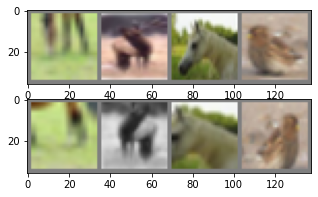

     horse       deer      horse       bird


In [9]:
# Let's take a view at how the positive-sample-pairs look like
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
dataiter = iter(train_loader)
(image1, image2), label = dataiter.next()

# show images
plt.figure(figsize=(6,3))
plt.subplot(2,1,1)
imshow(torchvision.utils.make_grid(image1[0:4,]))
plt.subplot(2,1,2)
imshow(torchvision.utils.make_grid(image2[0:4,]))
plt.show()

# print labels
print(' '.join('%10s' % classes[label[j]] for j in range(4)))

In [10]:
# Build the MoCo model
base_model = ResNet18  #Note: don't use ResNet18() here
# The value of k should be an integer multiple of batch size to facilitate enqueue and dequeue
model = MoCo(base_encoder=base_model, dim=128, K=10240, m=0.999, T=0.07, mlp=False)
model.cuda()

MoCo(
  (encoder_q): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (shortcut): Sequential()
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2

In [13]:
def accuracy(output, target, topk=(1,)):
    """Computes the accuracy over the k top predictions for the specified values of k"""
    with torch.no_grad():
        maxk = max(topk)
        batch_size = target.size(0)

        _, pred = output.topk(maxk, 1, True, True)
        pred = pred.t()
        correct = pred.eq(target.reshape(1, -1).expand_as(pred))

        res = []
        for k in topk:
            correct_k = correct[:k].reshape(-1).float().sum(0, keepdim=True)
            res.append(correct_k.mul_(100.0 / batch_size))
        return res

In [10]:
class AverageMeter(object):
    """Computes and stores the average and current value"""
    def __init__(self, name, fmt=':f'):
        self.name = name
        self.fmt = fmt
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

    def __str__(self):
        fmtstr = '{name} {val' + self.fmt + '} ({avg' + self.fmt + '})'
        return fmtstr.format(**self.__dict__)

In [13]:
def adjust_learning_rate(optimizer, epoch, initial_lr, schedule):
    """Decay the learning rate based on schedule"""
    lr = initial_lr
    for milestone in schedule:
        lr *= 0.1 if epoch >= milestone else 1.
    for param_group in optimizer.param_groups:
        param_group['lr'] = lr

In [14]:
# training
epochs =300
lr = 0.1
momentum = 0.9
weight_decay = 1e-4
schedule = [150, 220]
criterion = nn.CrossEntropyLoss().cuda()
optimizer = torch.optim.SGD(model.parameters(), lr, momentum=momentum, weight_decay=weight_decay)
for epoch in range(epochs):
    adjust_learning_rate(optimizer, epoch, lr, schedule)
    model.train()
    losses = AverageMeter('Loss', ':.4e')
    top1 = AverageMeter('Acc@1', ':6.2f')
    top5 = AverageMeter('Acc@5', ':6.2f')
    for i, (images, _) in enumerate(train_loader):
        images[0] = images[0].cuda(non_blocking=True)
        images[1] = images[1].cuda(non_blocking=True)
        # compute output
        output, target = model(im_q=images[0], im_k=images[1])
        loss = criterion(output, target)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        acc1, acc5 = accuracy(output, target, topk=(1, 5))
        losses.update(loss.item(), images[0].size(0))
        top1.update(acc1[0], images[0].size(0))
        top5.update(acc5[0], images[0].size(0))
        # print(loss, acc1, acc5)
    print(f'epoch {epoch} / {epochs}, loss: {losses.avg:.4f}, acc1: {top1.avg:.2f}, acc5: {top5.avg:.2f}')

epoch 0 / 300, loss: 6.4926, acc1: 5.47, acc5: 13.53
epoch 1 / 300, loss: 5.8061, acc1: 13.18, acc5: 30.46
epoch 2 / 300, loss: 5.6125, acc1: 19.21, acc5: 37.98
epoch 3 / 300, loss: 5.6493, acc1: 21.08, acc5: 39.32
epoch 4 / 300, loss: 5.6222, acc1: 22.99, acc5: 40.51
epoch 5 / 300, loss: 5.5861, acc1: 24.25, acc5: 41.73
epoch 6 / 300, loss: 5.4667, acc1: 26.70, acc5: 42.38
epoch 7 / 300, loss: 5.2864, acc1: 28.34, acc5: 44.18
epoch 8 / 300, loss: 5.1792, acc1: 28.80, acc5: 44.52
epoch 9 / 300, loss: 5.0466, acc1: 29.39, acc5: 45.94
epoch 10 / 300, loss: 5.0119, acc1: 30.35, acc5: 45.85
epoch 11 / 300, loss: 4.8993, acc1: 30.22, acc5: 46.81
epoch 12 / 300, loss: 4.8077, acc1: 30.82, acc5: 47.20
epoch 13 / 300, loss: 4.6638, acc1: 31.65, acc5: 48.43
epoch 14 / 300, loss: 4.6206, acc1: 31.64, acc5: 49.06
epoch 15 / 300, loss: 4.5360, acc1: 32.48, acc5: 50.18
epoch 16 / 300, loss: 4.4652, acc1: 32.77, acc5: 51.51
epoch 17 / 300, loss: 4.3902, acc1: 32.92, acc5: 51.94
epoch 18 / 300, loss:

* you can see the accuracy is not high, because in this tutorial, we just train MoCo on Cifar10, which is a small and simple dataset. Usually, we need to train self-supervised model on a complex dataset to get a well-trained model.

In [15]:
# save the model
torch.save({'state_dict': model.state_dict()}, 'moco_cifar10.pth')

##### Then we start to evaluate the feature quality leanrt by MoCo via linear probe
* we build a new resnet18, and load the parameters from the trained MoCo's encoder instead of the last fully-connected layer
* we initilize a new linear layer, and fraze all the layers before to perform linear probe

In [22]:
model_cls = ResNet18(num_classes=10)
for name, param in model_cls.named_parameters():
    if name not in ['linear.weight', 'linear.bias']:
        param.requires_grad = False
# init the fc layer
model_cls.linear.weight.data.normal_(mean=0.0, std=0.01)
model_cls.linear.bias.data.zero_()
checkpoint = torch.load('moco_cifar10.pth', map_location="cpu")
# rename moco pre-trained keys
state_dict = checkpoint['state_dict']
for k in list(state_dict.keys()):
    # retain only encoder_q up to before the embedding layer
    if k.startswith('encoder_q') and not k.startswith('encoder_q.linear'):
        # remove prefix
        state_dict[k[len("encoder_q."):]] = state_dict[k]
    # delete renamed or unused k
    del state_dict[k]
msg = model_cls.load_state_dict(state_dict, strict=False)
assert set(msg.missing_keys) == {"linear.weight", "linear.bias"}
model_cls = model_cls.cuda()

In [34]:
train_dataset = CIFAR10(root='/import/home/xliude/vs_projects/data', train=True, transform=train_transform)
val_dataset = CIFAR10(root='/import/home/xliude/vs_projects/data', train=False, transform=val_transform)
trainloader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True,\
    num_workers=16, pin_memory=True, sampler=None)
testloader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, shuffle=False, \
    num_workers=16, pin_memory=True)
loaders = {'train': trainloader, 'test': testloader}

In [24]:
criterion = nn.CrossEntropyLoss().cuda()
# optimize only the linear classifier
parameters = list(filter(lambda p: p.requires_grad, model_cls.parameters()))
assert len(parameters) == 2  # fc.weight, fc.bias
cls_lr = 30.
optimizer = torch.optim.SGD(parameters, lr=cls_lr, momentum=0.9, weight_decay=0.)

In [39]:
epochs = 100
schedule = [60, 80]
for epoch in range(epochs):
    adjust_learning_rate(optimizer, epoch, lr, schedule)
    for phase in ['train', 'test']:
        losses = AverageMeter('Loss', ':.4e')
        top1 = AverageMeter('Acc@1', ':6.2f')
        top5 = AverageMeter('Acc@5', ':6.2f')
        if phase == 'train':
            model_cls.train(True)
        else:
            model_cls.train(False)
        for i, (images, targets) in enumerate(loaders[re.findall('[a-zA-Z]+', phase)[0]]):
            images, targets = images.cuda(), targets.cuda()
            # compute output
            optimizer.zero_grad()
            outputs = model_cls(images)
            loss = criterion(outputs, targets)
            # print(loss)
            if phase == 'train':
                loss.backward()
                optimizer.step()
            # print(output.size(), target.size())
            acc1, acc5 = accuracy(outputs, targets, topk=(1, 5))
            # print(acc1, acc5)
            losses.update(loss.item(), images[0].size(0))
            top1.update(acc1.item(), images[0].size(0))
            top5.update(acc5.item(), images[0].size(0))
        # print(loss, acc1, acc5)
        if phase == 'train':
            print(f'epoch {epoch} / {epochs}, {phase}, loss: {losses.avg:.4f}')
        else:
            print(f'{phase}, loss: {losses.avg:.4f}, acc1: {top1.avg:.2f}, acc5: {top5.avg:.2f}')

epoch 0 / 100, train, loss: 1.1618
test, loss: 1.0634, acc1: 62.68, acc5: 96.21
epoch 1 / 100, train, loss: 1.1587
test, loss: 1.0712, acc1: 62.20, acc5: 96.10
epoch 2 / 100, train, loss: 1.1636
test, loss: 1.0788, acc1: 61.96, acc5: 96.15
epoch 3 / 100, train, loss: 1.1578
test, loss: 1.0594, acc1: 63.05, acc5: 96.46
epoch 4 / 100, train, loss: 1.1545
test, loss: 1.0627, acc1: 62.75, acc5: 96.14
epoch 5 / 100, train, loss: 1.1583
test, loss: 1.0626, acc1: 62.62, acc5: 96.23
epoch 6 / 100, train, loss: 1.1558
test, loss: 1.0546, acc1: 63.18, acc5: 96.44
epoch 7 / 100, train, loss: 1.1551
test, loss: 1.0656, acc1: 62.80, acc5: 96.36
epoch 8 / 100, train, loss: 1.1495
test, loss: 1.0891, acc1: 62.14, acc5: 96.06
epoch 9 / 100, train, loss: 1.1512
test, loss: 1.0709, acc1: 62.39, acc5: 96.30
epoch 10 / 100, train, loss: 1.1537
test, loss: 1.0625, acc1: 62.64, acc5: 96.22
epoch 11 / 100, train, loss: 1.1492
test, loss: 1.0659, acc1: 62.46, acc5: 96.29
epoch 12 / 100, train, loss: 1.1480
te

* The linear probe results is not satisfying because we didn't get a well-trained self-supervised model at first.

#### Let's take a look at a MoCo-v2 model trained on ImageNet, then finetune on Cifar10
This MoCo-v2 model is well-trained with enough data
* we choose a resnet50 pretrained on ImageNet by MoCo
* then we build a new resnet50, and load the parameters from the trained MoCo's encoder instead of the last fully-connected layer
* we initilize a new fully-connected layer, train it and finetune all the layers before

In [3]:
model_ft = models.__dict__['resnet50'](num_classes=10)
# You need to download the pretrained model from https://github.com/facebookresearch/moco
# then change the path where you put the downloaded model
checkpoint = torch.load('./pretrained_model/moco_v2.pth.tar', map_location="cpu")
# rename moco pre-trained keys
state_dict = checkpoint['state_dict']
for k in list(state_dict.keys()):
    # retain only encoder_q up to before the embedding layer
    if k.startswith('module.encoder_q') and not k.startswith('module.encoder_q.fc'):
        # remove prefix
        state_dict[k[len("module.encoder_q."):]] = state_dict[k]
    # delete renamed or unused k
    del state_dict[k]
msg = model_ft.load_state_dict(state_dict, strict=False)
assert set(msg.missing_keys) == {"fc.weight", "fc.bias"}
model_ft = model_ft.cuda()


In [4]:
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                        std=[0.229, 0.224, 0.225])
train_transform = transforms.Compose([
                    # transforms.RandomResizedCrop(224),
                    transforms.RandomHorizontalFlip(),
                    transforms.ToTensor(),
                    normalize,
                ])
val_transform = transforms.Compose([
                # transforms.Resize(256),
                # transforms.CenterCrop(224),
                transforms.ToTensor(),
                normalize,
            ])
train_dataset = CIFAR10(root='/import/home/xliude/vs_projects/data', train=True, transform=train_transform)
val_dataset = CIFAR10(root='/import/home/xliude/vs_projects/data', train=False, transform=val_transform)
batch_size = 256
trainloader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True,\
    num_workers=16, pin_memory=True, sampler=None)
testloader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, shuffle=False, \
    num_workers=16, pin_memory=True)
loaders = {'train': trainloader, 'test': testloader}

In [8]:
ft_lr = 0.1
parameters = list(filter(lambda p: p.requires_grad, model_ft.parameters()))
optimizer = torch.optim.SGD(parameters, lr=ft_lr, momentum=0.9, weight_decay=0.)

In [14]:
epochs = 100
schedule = [60, 80]
train_loss = []
test_loss = []
train_acc = []
test_acc = []
criterion = nn.CrossEntropyLoss().cuda()
for epoch in range(epochs):
    adjust_learning_rate(optimizer, epoch, ft_lr, schedule)
    for phase in ['train', 'test']:
        losses = AverageMeter('Loss', ':.4e')
        top1 = AverageMeter('Acc@1', ':6.2f')
        top5 = AverageMeter('Acc@5', ':6.2f')
        if phase == 'train':
            model_ft.train(True)
        else:
            model_ft.train(False)
        for i, (images, targets) in enumerate(loaders[re.findall('[a-zA-Z]+', phase)[0]]):
            images, targets = images.cuda(), targets.cuda()
            # compute output
            optimizer.zero_grad()
            outputs = model_ft(images)
            loss = criterion(outputs, targets)
            # print(loss)
            if phase == 'train':
                loss.backward()
                optimizer.step()
            # print(output.size(), target.size())
            acc1, acc5 = accuracy(outputs, targets, topk=(1, 5))
            # print(acc1, acc5)
            losses.update(loss.item(), images[0].size(0))
            top1.update(acc1.item(), images[0].size(0))
            top5.update(acc5.item(), images[0].size(0))
        # print(loss, acc1, acc5)
        if phase == 'train':
            train_loss.append(losses.avg)
            train_acc.append(top1.avg)
            print(f'epoch {epoch} / {epochs}, {phase}, loss: {losses.avg:.4f}')
        else:
            test_loss.append(losses.avg)
            test_acc.append(top1.avg)
            print(f'{phase}- loss: {losses.avg:.4f}, acc1: {top1.avg:.2f}, acc5: {top5.avg:.2f}')

epoch 0 / 100, train, loss: 1.4906
test- loss: 1.2524, acc1: 56.26, acc5: 94.31
epoch 1 / 100, train, loss: 0.9732
test- loss: 1.0135, acc1: 65.68, acc5: 96.35
epoch 2 / 100, train, loss: 0.8020
test- loss: 0.8610, acc1: 71.06, acc5: 97.33
epoch 3 / 100, train, loss: 0.7043
test- loss: 0.8619, acc1: 70.76, acc5: 97.83
epoch 4 / 100, train, loss: 0.6327
test- loss: 0.7348, acc1: 74.77, acc5: 98.17
epoch 5 / 100, train, loss: 0.5723
test- loss: 0.7570, acc1: 74.16, acc5: 98.24
epoch 6 / 100, train, loss: 0.5166
test- loss: 0.7636, acc1: 74.78, acc5: 98.34
epoch 7 / 100, train, loss: 0.4718
test- loss: 0.6580, acc1: 78.20, acc5: 98.38
epoch 8 / 100, train, loss: 0.4342
test- loss: 0.6776, acc1: 77.51, acc5: 98.68
epoch 9 / 100, train, loss: 0.3956
test- loss: 0.6178, acc1: 79.89, acc5: 98.96
epoch 10 / 100, train, loss: 0.3680
test- loss: 0.6064, acc1: 80.29, acc5: 98.90
epoch 11 / 100, train, loss: 0.3325
test- loss: 0.6285, acc1: 79.50, acc5: 98.95
epoch 12 / 100, train, loss: 0.3002
te

In [26]:
def plot(train_loss, test_loss, train_acc, test_acc):
    fontdict = {'size': 20}

    def get_fig(i, title):
        fig = plt.figure(i, figsize=(6, 3))
        ax = fig.add_subplot(111)
        #plt.title(title, fontsize=30, y=1.04)
        plt.xticks(fontsize=10)
        plt.yticks(fontsize=10)
        return fig, ax

    fig1, ax1 = get_fig(1, 'Loss of finetuning MoCo on Cifar10')
    fig2, ax2 = get_fig(2, 'Accuracy of finetuning MoCo on Cifar10')

    ax1.plot(train_loss,'b', linewidth=3, label='training')
    ax1.plot(test_loss,'r', linewidth=3, label='test')
    ax1.set_ylabel('loss',fontdict=fontdict)
    ax2.plot(train_acc,'b', linewidth=3, label='training')
    ax2.plot(test_acc,'r', linewidth=3, label='test')
    ax2.set_ylabel('accuracy',fontdict=fontdict)

    for ax in [ax1, ax2]:
        ax.set_xlabel('Number of epochs', fontdict=fontdict)
        ax.legend(loc='upper right', fontsize=10)

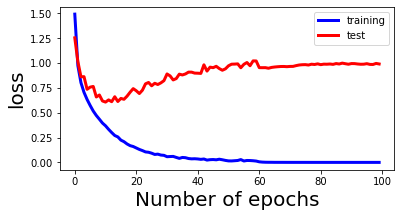

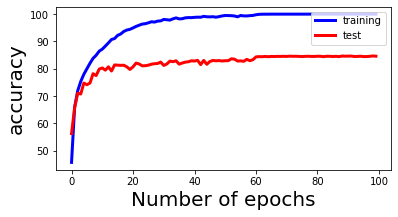

In [27]:
plot(train_loss, test_loss, train_acc, test_acc)
plt.show()

Although for the classification task on Cifar10, the result of self-supervised learning did not beat supervised learning. Self-supervised learning is still promising.
* It don't need labels. And for the dataset with noisy label or imbalanced distribution, supervised learning can be easily mislead, but nor do self-supervised learning.
* Usually, self-supervised learning can learn more informative and transferable features, which can be used for many down-streaming tasks, as object detection and instance segmentation.